# ECE276C - Assignment 1 - Classical Control

In this file we will analyze the two joint robot arm and racecar classical control problem

## Two Joint Robotic Arm

#### Imports

In [71]:
import gym
import pybulletgym.envs
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import Image

#### Environment Set-up

In [72]:
env_id = "ReacherPyBulletEnv-v0"
env = gym.make(env_id)
# Create Environment 
env.reset()
print()

/Users/stevengnow/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


#### Two-joint Arm - Question 1 - Forward Kinematics

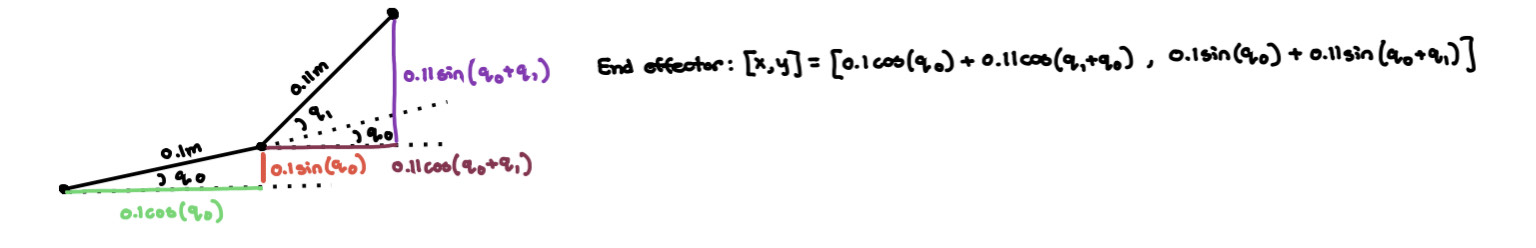

In [85]:
Image("Images/Forward_Kinematics.JPG")

In [73]:
def getForwardModel(q0,q1):
    '''
    Inputs:
        q0: angle of first arm (radians)
        q1: angle of second arm (radians)
    Output:
        [x,y]: end effector position in cartesian space
    '''
    x = 0.1*np.cos(q0) + 0.11*np.cos(q0+q1)
    y = 0.1*np.sin(q0) + 0.11*np.sin(q0+q1)
    
    return np.array([x,y])

#### Two-joint Arm - Question 2 - Jacobian

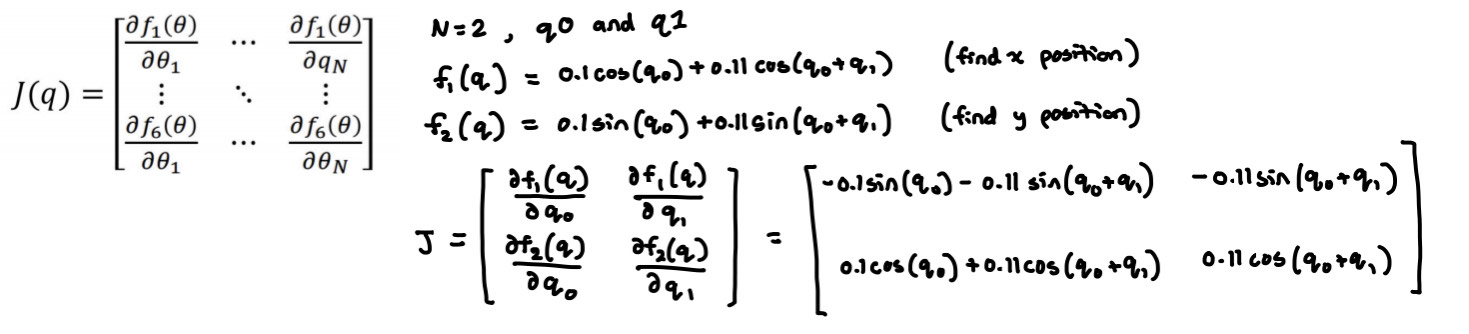

In [86]:
Image("Images/Jacobian.JPG")

In [74]:
def getJacobian(q0,q1):
    '''
    Inputs:
        q0: angle of first arm (radians)
        q1: angle of second arm (radians) 
    Output:
        J: Jacobian (2x2)
    '''
    J = np.zeros((2,2))
    J[0,0] = -0.1*np.sin(q0) - 0.11*np.sin(q0+q1)
    J[0,1] = -0.11*np.sin(q0+q1)
    J[1,0] = 0.1*np.cos(q0) + 0.11*np.cos(q0+q1)
    J[1,1] = 0.11*np.cos(q0+q1)
    return J

#### Two-joint Arm - Question 3 - Closed Loop End Effector Trajectory PD Control

To calculate the Jacobian's inverse, we use the moore-penrose pseudo-inverse, which calculates the generalized inverse of a matrix using its singular-value decomposition (SVD).

In [75]:
# Discretize the reference trajectory
d = 100 
a = np.linspace(-np.pi,np.pi,d)
x_ref = np.zeros((2,d))
x_ref[0] = (0.19 + 0.02*np.cos(4*a))*np.cos(a)   # x-coordinates
x_ref[1] = (0.19 + 0.02*np.cos(4*a))*np.sin(a)   # y-coordinates

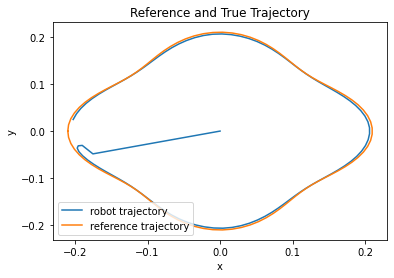

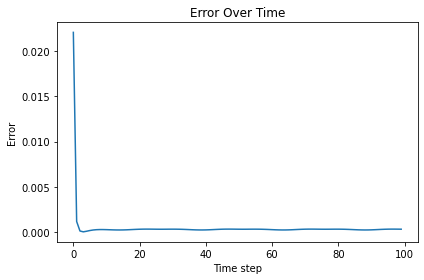

Mean Squared Error: 0.0005209274113222127


In [76]:
# Initialize q0, q1, x, x_ref, and the error
q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()
x = getForwardModel(q0,q1)
x_r = x_ref[:,0]
e_p = x_r - x

# Closed Loop PD Control
K = 0.5
K_d = 0.1
traj = np.zeros((2,d))
for i in range(1,d):
    x = getForwardModel(q0,q1)   # current robot point
    traj[:,i] = x
    x_r = x_ref[:,i]    # current reference point
    e = x_r - x  
    dx = K*(e) + K_d*(e - e_p)
    e_p = e
    J = getJacobian(q0,q1)
    dq = np.dot(np.linalg.pinv(J),dx)
    q0 = q0 + dq[0]
    q1 = q1 + dq[1]
    
# Plot the Results of the PD Controller
plt.title('Reference and True Trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(traj[0],traj[1], label = 'robot trajectory')
plt.plot(x_ref[0],x_ref[1], label = 'reference trajectory')
plt.legend(loc = 3)
plt.show()

# Plot the Error over time
error = ((traj - x_ref)**2).mean(axis = 0)
t = np.linspace(0,99,100)
plt.title('Error Over Time')
plt.xlabel('Time step')
plt.ylabel('Error')
plt.plot(t,error)
plt.tight_layout()
plt.show()

# Calculate MSE Error
mse = ((traj - x_ref)**2).mean(axis = None)
print('Mean Squared Error:', mse)

#### Two-joint Arm - Quesetion 4 - The Inverse Kinematic Solutions

Below are the two methods of solving the inverse kinematics problem. The first is via gradient descent, and the second is the analytical solution

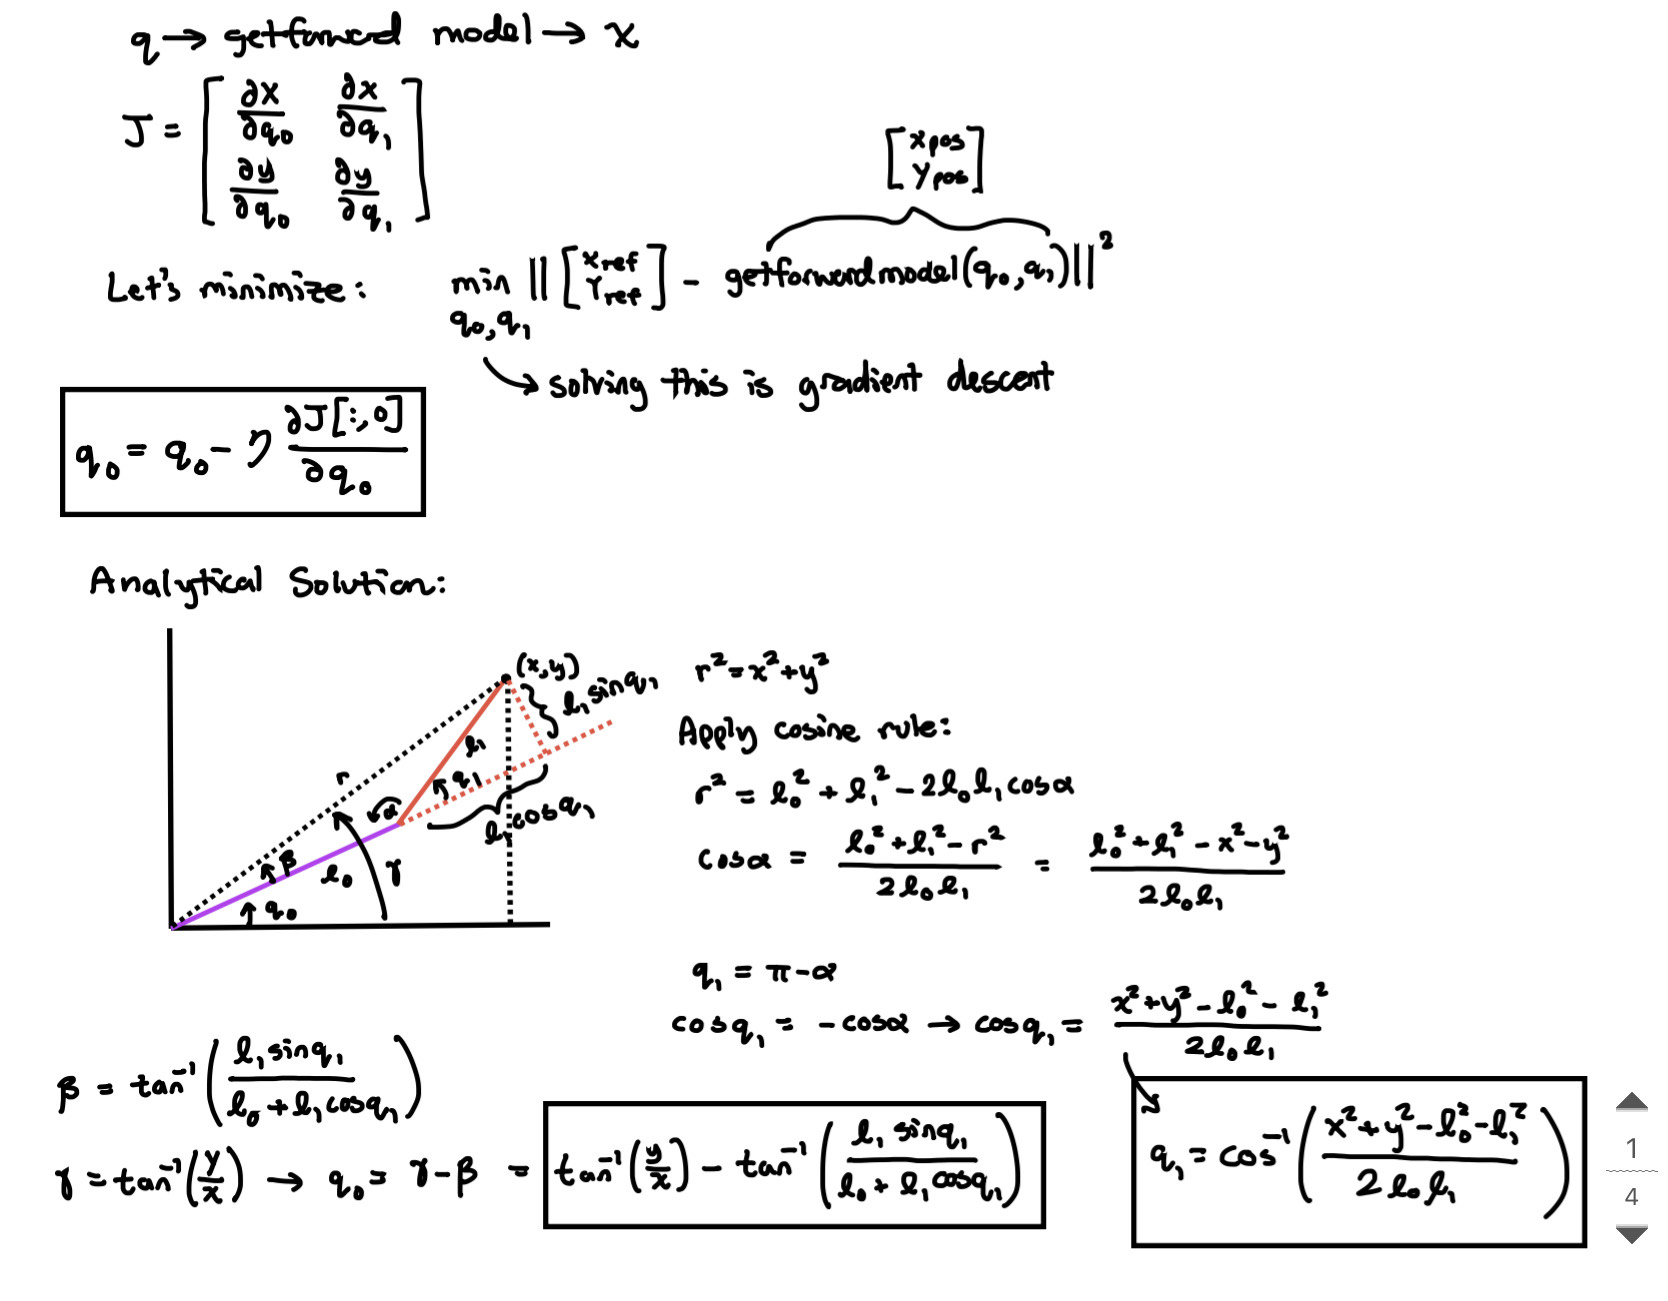

In [82]:
Image("Images/Inverse_Kinematics.JPG")

An issue that comes with the analytical solution is that there are actually 2 solutions for each point (you can imagine it as completing the parallelogram). This means one cannot just simply cycle between the two options as valid arm positions. In the real world, that would amount to the robot rapidly moving its arms instead of smoothly following a trajectory.

#### Two-joint Arm - Question 5 - Closed Loop Q Error Trajectory PD Control 

In [77]:
def inverse_kinematics_q1(x):
    '''
    Input: 
        x: point in cartesian space (2x1)
    Output:
        q1: joint arm angle
    '''
    return np.arccos((x[0]**2 + x[1]**2 - 0.1**2 - 0.11**2)/(2*0.1*0.11))

def inverse_kinematics_q0(x,q1):
    '''
    Input:
        x: point in cartesian space (2x1)
        q1: joint arm angle
    Ouput:
        q0: central arm angle
    '''
    return math.atan2(x[1],x[0]) - math.atan2((0.11*np.sin(q1)),(0.1 + 0.11*np.cos(q1)))

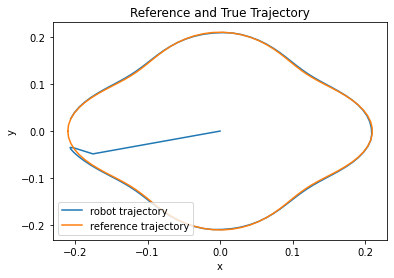

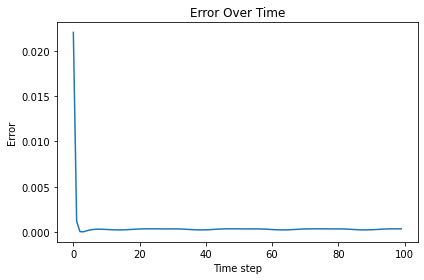

Mean Squared Error: 0.0005304186398434862


In [78]:
# Populate the reference angles
q_ref = np.zeros((2,d))
for i in range(d):
    q_ref[1,i] = inverse_kinematics_q1(x_ref[:,i])
    q_ref[0,i] = inverse_kinematics_q0(x_ref[:,i], q_ref[1,i])
    
# Initialize q0, q1, error
q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()
e_p = q_ref[:,0] - [q0,q1]
    
# Closed Loop PD Control
K = 0.5
K_d = 0.1
traj = np.zeros((2,d))
for i in range(1,d):
    x = getForwardModel(q0,q1)
    traj[:,i] = x
    q_r = q_ref[:,i]
    e = q_r - [q0,q1] 
    dq = K*e + K_d*(e - e_p)
    q0 = q0 + dq[0]
    q1 = q1 + dq[1]
    e_p = e
    
# Plot the Results of the PD Controller
plt.title('Reference and True Trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(traj[0],traj[1], label = 'robot trajectory')
plt.plot(x_ref[0],x_ref[1], label = 'reference trajectory')
plt.legend(loc = 3)
plt.show()

# Plot the Error over time
error = ((traj - x_ref)**2).mean(axis = 0)
t = np.linspace(0,99,100)
plt.title('Error Over Time')
plt.xlabel('Time step')
plt.ylabel('Error')
plt.plot(t,error)
plt.tight_layout()
plt.show()

# Calculate MSE Error
mse = ((traj - x_ref)**2).mean(axis = None)
print('Mean Squared Error:', mse)

Gaines used: ```K_p = 0.5``` and ```K_d = 0.1```

## Race Car on Track

To run the Race Car code, run ```Racecar.py```

#### Question 1

For each of the senarios ```circle```, ```figure eight```, and ```linear```, I used a PD controller (Proportional and derivative controller) to control the steering angle of the racecar. We are given the world frame coordinates of the car and the reference position it should reach. We will describe these points as ```(x,y)``` and ```h``` respectively.  
Firstly, we will take the reference point and convert it into the car frame. By doing this, we can find the change in ```x``` and change in ```y``` between the car and ```h```. The following formula completes this for us:   

\\( P^c_h = T^c_w * P^w_h = (R^w_c)^T(P^w_h - P^w_c)\\)  

We already have the values for ```theta``` used in the rotation matrix, and thus the above equation can be solved.

Next, since we have the value for \\(P^c_h\\), we can now use it as the error metric, as one can extract the change in ```x``` and ```y``` from this. We finally take the inverse tangent of the ```change in y / change in x``` to produce the error.  

Finally, the error is scaled by ```K_p```. Throughout the loop, the difference between the current and past error is scaled by ```K_d```. These are summed together and create our final angle.  

To keep a constant velocity, we create a threshold (on / off) representation of the ```thrust```. As soon as the velocity reaches a certain point (in our case it is about ```12m/s```, we cut off the thrust, and move at the constant velocity.  

The gains for all tracks was ```K_p = 3```, ```K_d = 0.1```

#### Question 2 

The following are the plots for each of the three cases

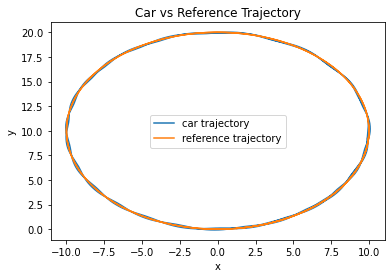

In [79]:
Image("Images/Circle_tracking.png")

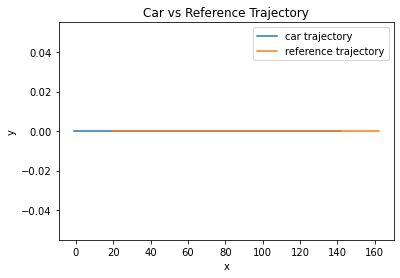

In [80]:
Image("Images/Linear_tracking.png")

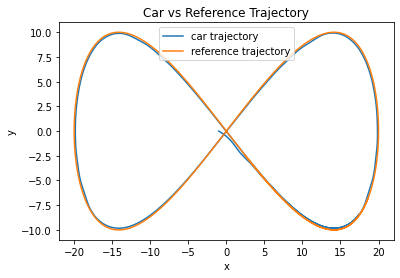

In [81]:
Image("Images/Figure8_tracking.png")